Nama: Syarani Afa Natira Kusumah<br>
NIM: 25020378464 <br>
Referensi code: https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi%20Label%20Text%20Classification%20using%20BERT%20PyTorch/bert_multilabel_pytorch_standard.ipynb<br>


In [ ]:
!pip install PySastrawi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict
from wordcloud import WordCloud
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import string
string.punctuation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load and preprocess data

In [ ]:
df = pd.read_csv("data_1D.csv")
df.head()

,Unnamed: 0,index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,0,9320,USER wkwkwkw akhirnya antek Amerika ini pasang...,0,0,0,0,0,0,0,0,0
1,1,3964,Terlalu suuzon nih rezim URL,1,0,1,0,0,0,0,0,1
2,2,8551,"Mau tanya sama guntur romli, Bener gak neh :;",0,0,0,0,0,0,0,0,0
3,3,12366,Genosida Muslim Rohingya oleh Teroris Budha My...,1,0,0,1,1,0,0,0,0
4,4,6271,USER USER SubhanAllah sekolah di sekolah krist...,0,0,0,0,0,0,0,0,0


In [ ]:
df.isna().sum()

Unnamed: 0       0
index            0
Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
dtype: int64

In [ ]:
labels = ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']

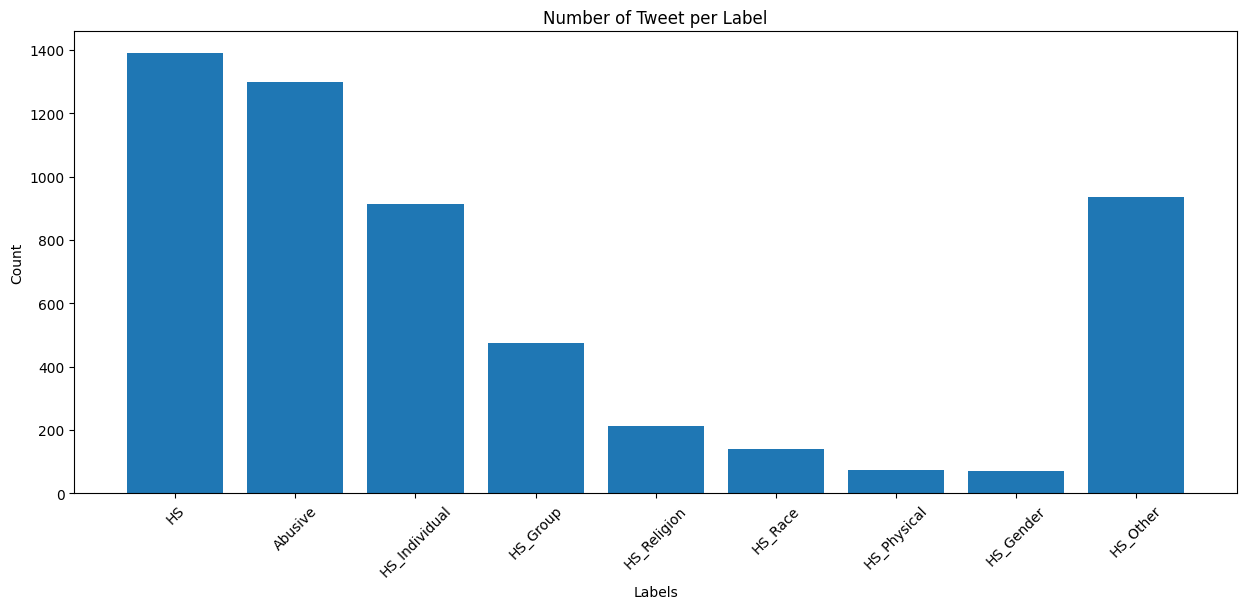

In [ ]:
# Count the number of occurrences of each label
label_counts = {label: df[label].sum() for label in labels}

# Create a bar chart
plt.figure(figsize=(15, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Number of Tweet per Label')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Load library
alay_dict = pd.read_csv("new_kamusalay.csv", encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'})

abusive_dict = pd.read_csv("abusive.csv")['ABUSIVE'].tolist()

Disini saya menggunakan kamus alay berisi kata-kata slang dan kata-kata formal pada bahasa Indonesia. Serta, kamus yang berisikian kata-kata kasar pada bahasa Indonesia.<br><br>

Sumber:<br>
https://github.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/blob/master/new_kamusalay.csv


In [ ]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [ ]:
df = df.drop(columns=['Unnamed: 0', 'index'])
print("Shape: ", df.shape)
df.tail(15)

Shape:  (3293, 10)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
3278,USER IYAAA SAS KEBETULAN BGT KEMAREN MASIH DI ...,0,0,0,0,0,0,0,0,0
3279,Sedikit sedikit lapor apa gak ada habisnya ini...,1,0,1,0,0,0,0,0,1
3280,"USER Udah dmcin ae zon, bilang kampang gitu. k...",1,1,1,0,0,0,0,0,1
3281,USER Bukan nya elu dan gerombolan elu malah le...,1,0,1,0,0,0,0,0,1
3282,Orang punya saksi anjing dikasus babi.. Tolol URL,1,1,1,0,0,0,0,0,1
3283,USER Iyup saya juga khawatir.\n\nBukan karena ...,0,0,0,0,0,0,0,0,0
3284,"USER USER USER USER USER Neng andi, ngopi dulu...",1,1,1,0,0,0,1,0,0
3285,USER Anti hindu',1,0,1,0,1,0,0,0,0
3286,USER USER Jilbab tapi akhlak bagai pecun\nCuih...,1,1,1,0,0,0,0,1,0
3287,USER kalau mau kasarnya lagi sih\n\nkakean coc...,1,1,1,0,0,0,0,0,1


In [ ]:
# Function to count the number of labels 0 and 1 for each label column
def count_labels(data, labels):
    counts = {}
    for column in labels:
        counts[column] = data[column].value_counts().to_dict()
    return counts

counts = count_labels(df, labels)

for column, count in counts.items():
    print(f"Label {column}")
    print(f"0: {count.get(0, 0)}")
    print(f"1: {count.get(1, 0)}")
    print()

Label HS
0: 1904
1: 1389

Label Abusive
0: 1993
1: 1300

Label HS_Individual
0: 2380
1: 913

Label HS_Group
0: 2817
1: 476

Label HS_Religion
0: 3081
1: 212

Label HS_Race
0: 3153
1: 140

Label HS_Physical
0: 3218
1: 75

Label HS_Gender
0: 3224
1: 69

Label HS_Other
0: 2356
1: 937



Untuk label HS, terdapat 1904 tweet yang tidak termasuk label tersebut, dan terdapat 1389 tweet yang termasuk dalam label tersebut.

In [ ]:
def count_toxic_nontoxic(df):
    # Toxic if one of the labels is 1
    toxic_condition = (df['HS'] == 1) | (df['Abusive'] == 1) | (df['HS_Individual'] == 1) | (df['HS_Group'] == 1) | (df['HS_Religion'] == 1) | (df['HS_Race'] == 1) | (df['HS_Physical'] == 1) | (df['HS_Gender'] == 1) | (df['HS_Other'] == 1)
    toxic_count = df[toxic_condition].shape[0]

    # Non-toxic if all labels are 0
    nontoxic_condition = (df['HS'] == 0) & (df['Abusive'] == 0) & (df['HS_Individual'] == 0) & (df['HS_Group'] == 0) & (df['HS_Religion'] == 0) & (df['HS_Race'] == 0) & (df['HS_Physical'] == 0) & (df['HS_Gender'] == 0) & (df['HS_Other'] == 0)
    nontoxic_count = df[nontoxic_condition].shape[0]

    print("Toxic: ", toxic_count)
    print("Non-toxic: ", nontoxic_count)

count_toxic_nontoxic(df)

Toxic:  1852
Non-toxic:  1441


Disini saya ingin melihat tweet yang tergolong toxic dan non-toxic berdasarkan semua label dalam dataset. Tweet yang dianggap toxic jika salah satu label bernilai 1, dan non-toxic jika semua label bernilai 0. Terlihat bahwa terdapat 1852 tweet yang tergolong toxic dan 1441 tweet yang tergolong non-toxic.

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

id_stopword_dict = stopwords.words('indonesian')


def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('RT',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('USER', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub(':', ' ', text)
    text = re.sub(';', ' ', text)
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_emoticon_byte(text):
    text = text.replace("\\", " ")
    text = re.sub('x..', ' ', text)
    text = re.sub(' n ', ' ', text)
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def remove_early_space(text):
    if text[0] == ' ':
        return text[1:]
    else:
        return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

In [ ]:
def preprocess(text):
    text = lowercase(text)
    text = remove_unnecessary_char(text)
    text = remove_emoticon_byte(text)
    text = remove_nonaplhanumeric(text)
    text = remove_early_space(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    return text

In [ ]:
df['Tweet'] = df['Tweet'].apply(preprocess)
df.sample(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
2510,bajing gue peduli aksi aksi kemarin murni pang...,1,1,1,0,1,0,0,0,0
3027,malas duduk h orang kg budaya kg duduk h buday...,0,0,0,0,0,0,0,0,0
157,usir cina 1 kota turun turun anak anak siloam ...,1,0,0,1,0,0,0,0,1
1535,bacot jakarta,1,1,1,0,0,0,0,0,1
873,hai kunyuk paham ya prabowo subianto calon pre...,1,1,1,0,0,0,0,0,1
3025,lihat agama mayoritas tindas aniaya b i indonesia,1,0,0,1,1,0,0,0,0
775,aduh mas mending anggap komunis komunis kumis ...,0,0,0,0,0,0,0,0,0
1606,nyata fadli zon potensi korupsi pilih kepala d...,0,0,0,0,0,0,0,0,0
1806,prabowo calon presiden 2019 presiden rakyat pi...,0,0,0,0,0,0,0,0,0
1690,rela telepon ber jam jam habis topik telepon d...,0,0,0,0,0,0,0,0,0


In [ ]:
#df.to_csv('preprocessed_indonesian_tweet.csv', index=False)

In [ ]:
tweets_corpus = []

for tweet in df['Tweet'].str.split():
    for word in tweet:
        if len(word) > 0 and word in abusive_dict:
            tweets_corpus.append(word)

In [ ]:
counter_tweets = Counter(tweets_corpus).most_common()[:1000]

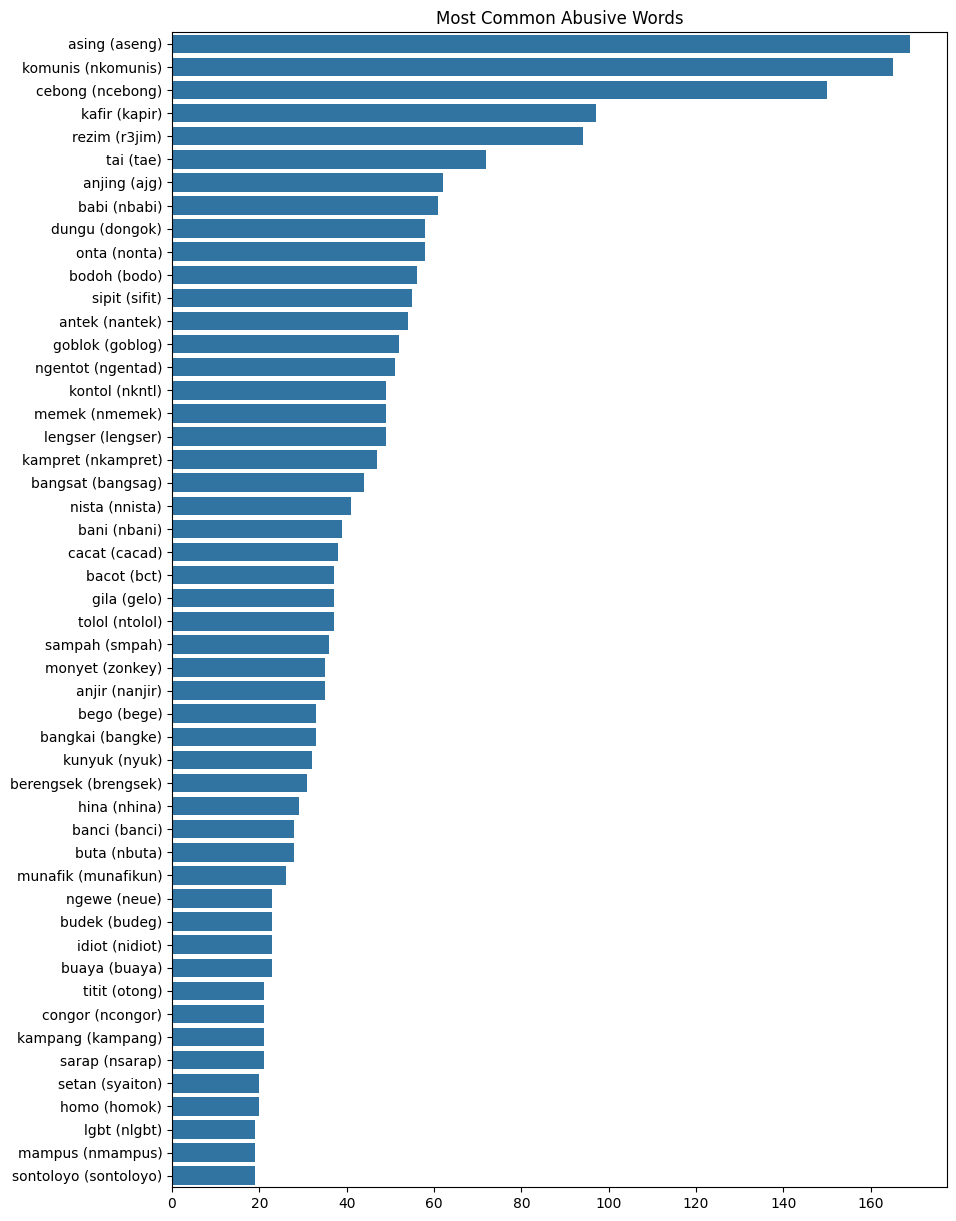

In [ ]:
top_tweets = OrderedDict(counter_tweets)

show_only = 50

keys = list(top_tweets.keys())
vals = [top_tweets[k] for k in keys]

original_slang = []
for word in keys:
    if word in alay_dict['replacement'].values:
        original_slang.append(alay_dict.loc[alay_dict['replacement'] == word, 'original'].values[0])
    else:
        original_slang.append(word)

combined_words = [f'{keys[i]} ({original_slang[i]})' for i in range(len(keys))]

plt.figure(figsize=(10, 15))
sns.barplot(x=vals[:show_only], y=combined_words[:show_only])
plt.title('Most Common Abusive Words')
plt.show()

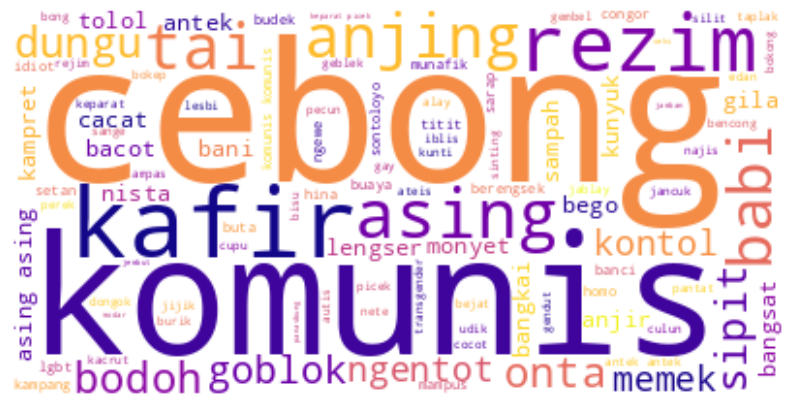

In [ ]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 8))
tokens_ = ' '.join(tweets_corpus)
wc_ = WordCloud(max_words=100, background_color='white', max_font_size=100, colormap='plasma').generate(tokens_)
axes.axis("off")
axes.imshow(wc_, interpolation="bilinear")
plt.show()

##Modeling

In [ ]:
# Split dataset
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

Train: 2634
Validation: 329
Test: 330


In [ ]:
# Hyperparameter
TOKENIZER = BertTokenizer.from_pretrained('bert-base-cased')
MAX_LEN = df['Tweet'].str.split().str.len().max()
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-05

In [ ]:
class BuildDataset(Dataset):
    def __init__(self, df):
        self.labels = df.iloc[:, 1:].values
        self.texts = df['Tweet'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = TOKENIZER(text, padding='max_length', max_length=MAX_LEN, truncation=True, return_tensors="pt")

        return {key: val.squeeze(0) for key, val in encoding.items()}, torch.tensor(labels, dtype=torch.float)

In [ ]:
class BertClassifier(nn.Module):
  def __init__(self, dropout=0.5):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, 9)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_id, mask):
    _, pooled_output = self.bert(input_ids = input_id, attention_mask = mask, return_dict = False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    sigmoid_output = self.sigmoid(linear_output)

    return sigmoid_output

model = BertClassifier()

In [ ]:
def calculate_accuracy(predict, labels, threshold = 0.5):
    rounded_predict = torch.round(predict)
    correct = (rounded_predict == labels).float()
    accuracy = correct.sum() / (len(correct) * labels.shape[1])
    return accuracy

In [ ]:
def train(model, train_data, val_data, lr, epoch):
  train, val = BuildDataset(train_data), BuildDataset(val_data)

  train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
  val_loader = torch.utils.data.DataLoader(train,
                                            batch_size = BATCH_SIZE)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  criterion = nn.BCEWithLogitsLoss()
  optimizer = Adam(model.parameters(), lr = LR)

  if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()

  for i in range(epoch):
    total_loss_train = 0
    total_acc_train = 0
    model.train()
    train_predict, train_labels = [], []

    for train_input, train_label in tqdm(train_loader):
      train_label = train_label.to(device)
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].to(device)

      output = model(input_id, mask)

      loss = criterion(output, train_label)
      total_loss_train += loss.item()
      acc = calculate_accuracy(output, train_label)
      total_acc_train += acc.item()

      model.zero_grad()
      loss.backward()
      optimizer.step()

      train_predict.extend(torch.round(output).detach().cpu().numpy())
      train_labels.extend(train_label.detach().cpu().numpy())

    total_loss_val = 0
    total_acc_val = 0
    model.eval()
    val_predict, val_labels = [], []

    with torch.no_grad():
      for val_input, val_label in val_loader:
          val_label = val_label.to(device)
          mask = val_input['attention_mask'].to(device)
          input_id = val_input['input_ids'].to(device)

          output = model(input_id, mask)

          loss = criterion(output, val_label)
          total_loss_val += loss.item()

          acc = calculate_accuracy(output, val_label)
          total_acc_val += acc.item()

          val_predict.extend(torch.round(output).detach().cpu().numpy())
          val_labels.extend(val_label.detach().cpu().numpy())

    print(f'Epochs: {i + 1} | Train Loss: {total_loss_train / len(train_loader): .3f} \ | Train Accuracy: {total_acc_train / len(train_loader): .3f} \ | Val Loss: {total_loss_val / len(val_loader): .3f} \ | Val Accuracy: {total_acc_val / len(val_loader): .3f}')

  print("Training Classification Report")
  print(classification_report(train_labels, train_predict, target_names = train_data.columns[1:]))

  print("Validation Classification Report")
  print(classification_report(val_labels, val_predict, target_names = val_data.columns[1:]))

  val_accuracy = total_acc_val/len(val_loader)
  return val_accuracy

In [ ]:
def evaluation(model, test_data):
  test = BuildDataset(test_data)
  test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  if use_cuda:
    model = model.cuda()

  total_acc_test = 0
  test_predict, test_labels = [], []

  model.eval()
  with torch.no_grad():
    for test_input, test_label in test_loader:
      test_label = test_label.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].to(device)

      output = model(input_id, mask)

      acc = calculate_accuracy(output, test_label)
      total_acc_test += acc.item()

      test_predict.extend(torch.round(output).detach().cpu().numpy())
      test_labels.extend(test_label.detach().cpu().numpy())

  print(f'Test Accuracy: {total_acc_test / len(test_loader): .3f}')

  print("Test Classification Report")
  print(classification_report(test_labels, test_predict, target_names = test_data.columns[1:]))

In [ ]:
train(model, train_df, val_df, LR, EPOCHS)

100%|██████████| 165/165 [00:33<00:00,  4.87it/s]


Epochs: 1 | Train Loss:  0.757 \ | Train Accuracy:  0.773 \ | Val Loss:  0.709 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.42it/s]


Epochs: 2 | Train Loss:  0.706 \ | Train Accuracy:  0.813 \ | Val Loss:  0.700 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.49it/s]


Epochs: 3 | Train Loss:  0.700 \ | Train Accuracy:  0.813 \ | Val Loss:  0.698 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.44it/s]


Epochs: 4 | Train Loss:  0.698 \ | Train Accuracy:  0.812 \ | Val Loss:  0.696 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 5 | Train Loss:  0.696 \ | Train Accuracy:  0.812 \ | Val Loss:  0.695 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.41it/s]


Epochs: 6 | Train Loss:  0.696 \ | Train Accuracy:  0.813 \ | Val Loss:  0.695 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.45it/s]


Epochs: 7 | Train Loss:  0.695 \ | Train Accuracy:  0.812 \ | Val Loss:  0.695 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 8 | Train Loss:  0.695 \ | Train Accuracy:  0.813 \ | Val Loss:  0.694 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.36it/s]


Epochs: 9 | Train Loss:  0.692 \ | Train Accuracy:  0.821 \ | Val Loss:  0.689 \ | Val Accuracy:  0.835


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 10 | Train Loss:  0.688 \ | Train Accuracy:  0.835 \ | Val Loss:  0.685 \ | Val Accuracy:  0.842
Training Classification Report
               precision    recall  f1-score   support

           HS       0.82      0.28      0.42      1120
      Abusive       0.86      0.31      0.46      1049
HS_Individual       0.00      0.00      0.00       731
     HS_Group       0.00      0.00      0.00       389
  HS_Religion       0.00      0.00      0.00       175
      HS_Race       0.00      0.00      0.00       109
  HS_Physical       0.00      0.00      0.00        61
    HS_Gender       0.00      0.00      0.00        56
     HS_Other       0.81      0.03      0.06       755

    micro avg       0.84      0.15      0.25      4445
    macro avg       0.28      0.07      0.10      4445
 weighted avg       0.55      0.15      0.22      4445
  samples avg       0.13      0.08      0.09      4445

Validation Classification Report
               precision    recall  f1-score   support

  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

0.8418350241400979

* Precision mengukur akurasi prediksi model, yaitu proporsi prediksi yang benar dari keseluruhan prediksi yang dibuat untuk kelas tersebut.
* Recall mengukur sensitivitas model, yaitu proporsi kasus yang benar-benar positif yang berhasil ditemukan oleh model.
* F1-Score adalah rata-rata harmonis dari precision dan recall, memberikan gambaran umum performa model untuk setiap kelas.

Pada kategori HS (Hate Speech) terlihat bahwa nilai precission-nya cukup tinggi (0.82), namun recall-nya rendah (0.28), yang berarti model sering salah tidak mendeteksi hate speech ketika ada. Begitu pula dengan kategori Abusive dan HS_Other, yang memiliki nilai precision tinggi tetapi recall tetap rendah. Kategori lainnya seperti HS_Individual, HS_Group, HS_Religion, HS_Race, HS_Physical, dan HS_Gender memiliki precision, recall, dan F1-score yang sangat rendah (0.00), yang berarti model gagal mendeteksi kategori-kategori ini sama sekali.

In [ ]:
evaluation(model, test_df)

Test Accuracy:  0.848
Test Classification Report
               precision    recall  f1-score   support

           HS       0.82      0.30      0.43       135
      Abusive       0.94      0.37      0.53       126
HS_Individual       0.00      0.00      0.00        92
     HS_Group       0.00      0.00      0.00        43
  HS_Religion       0.00      0.00      0.00        16
      HS_Race       0.00      0.00      0.00        14
  HS_Physical       0.00      0.00      0.00         6
    HS_Gender       0.00      0.00      0.00         6
     HS_Other       0.74      0.23      0.35        99

    micro avg       0.84      0.20      0.33       537
    macro avg       0.28      0.10      0.15       537
 weighted avg       0.56      0.20      0.30       537
  samples avg       0.12      0.10      0.10       537



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hasil pada data validasi menunjukan pola yang serupa dengan data testnya. Kategori HS, Abusive, dan HS_Other memiliki precision yang lebih tinggi, tetapi recall tetap rendah. Kategori lainnya masih memiliki kinerja yang buruk dengan precision, recall, dan F1-score mendekati 0.

## Turned model

In [ ]:
from torch.nn.utils import clip_grad_norm_

class BertClassifier2(nn.Module):
    def __init__(self, dropout=0.2):
        super(BertClassifier2, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 9)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        sigmoid_output = self.sigmoid(linear_output)
        return sigmoid_output

model2 = BertClassifier2()

def train_with_early_stopping(model, train_data, val_data, lr, epoch, patience=3):
    train, val = BuildDataset(train_data), BuildDataset(val_data)
    train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=lr)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    best_val_loss = float('inf')
    patience_counter = 0

    for i in range(epoch):
        total_loss_train = 0
        total_acc_train = 0
        model.train()

        for train_input, train_label in tqdm(train_loader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].to(device)

            optimizer.zero_grad()
            output = model(input_id, mask)
            loss = criterion(output, train_label)
            total_loss_train += loss.item()
            acc = calculate_accuracy(output, train_label)
            total_acc_train += acc.item()

            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss_val = 0
        total_acc_val = 0
        model.eval()

        with torch.no_grad():
            for val_input, val_label in val_loader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].to(device)

                output = model(input_id, mask)
                loss = criterion(output, val_label)
                total_loss_val += loss.item()
                acc = calculate_accuracy(output, val_label)
                total_acc_val += acc.item()

        avg_val_loss = total_loss_val / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {i+1}")
            break

        print(f'Epochs: {i + 1} | Train Loss: {total_loss_train / len(train_loader): .3f} \ | Train Accuracy: {total_acc_train / len(train_loader): .3f} \ | Val Loss: {total_loss_val / len(val_loader): .3f} \ | Val Accuracy: {total_acc_val / len(val_loader): .3f}')

Pada model kedua ini saya menggunakan:
- Menambahkan Dropout dengan rate 0.2 untuk mencegah overfitting.
- Membuat fungsi train_with_early_stopping untuk melatih model dengan menggunakan teknik early stopping untuk mencegah overfitting.
- Menggunakan loss function BCEWithLogitsLoss yang cocok untuk multilabel classification.

In [ ]:
train(model2, train_df, val_df, 5e-4, 20)

100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 1 | Train Loss:  0.751 \ | Train Accuracy:  0.778 \ | Val Loss:  0.707 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 2 | Train Loss:  0.704 \ | Train Accuracy:  0.812 \ | Val Loss:  0.700 \ | Val Accuracy:  0.812


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 3 | Train Loss:  0.698 \ | Train Accuracy:  0.813 \ | Val Loss:  0.695 \ | Val Accuracy:  0.814


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 4 | Train Loss:  0.693 \ | Train Accuracy:  0.826 \ | Val Loss:  0.686 \ | Val Accuracy:  0.848


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 5 | Train Loss:  0.687 \ | Train Accuracy:  0.844 \ | Val Loss:  0.684 \ | Val Accuracy:  0.844


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 6 | Train Loss:  0.682 \ | Train Accuracy:  0.857 \ | Val Loss:  0.677 \ | Val Accuracy:  0.870


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 7 | Train Loss:  0.679 \ | Train Accuracy:  0.866 \ | Val Loss:  0.675 \ | Val Accuracy:  0.873


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 8 | Train Loss:  0.675 \ | Train Accuracy:  0.879 \ | Val Loss:  0.671 \ | Val Accuracy:  0.882


100%|██████████| 165/165 [00:30<00:00,  5.48it/s]


Epochs: 9 | Train Loss:  0.670 \ | Train Accuracy:  0.892 \ | Val Loss:  0.664 \ | Val Accuracy:  0.908


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 10 | Train Loss:  0.666 \ | Train Accuracy:  0.902 \ | Val Loss:  0.662 \ | Val Accuracy:  0.913


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 11 | Train Loss:  0.663 \ | Train Accuracy:  0.908 \ | Val Loss:  0.662 \ | Val Accuracy:  0.914


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 12 | Train Loss:  0.660 \ | Train Accuracy:  0.914 \ | Val Loss:  0.657 \ | Val Accuracy:  0.920


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 13 | Train Loss:  0.659 \ | Train Accuracy:  0.916 \ | Val Loss:  0.656 \ | Val Accuracy:  0.923


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 14 | Train Loss:  0.658 \ | Train Accuracy:  0.918 \ | Val Loss:  0.654 \ | Val Accuracy:  0.927


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 15 | Train Loss:  0.656 \ | Train Accuracy:  0.922 \ | Val Loss:  0.653 \ | Val Accuracy:  0.929


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 16 | Train Loss:  0.654 \ | Train Accuracy:  0.925 \ | Val Loss:  0.652 \ | Val Accuracy:  0.929


100%|██████████| 165/165 [00:30<00:00,  5.47it/s]


Epochs: 17 | Train Loss:  0.653 \ | Train Accuracy:  0.926 \ | Val Loss:  0.651 \ | Val Accuracy:  0.932


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 18 | Train Loss:  0.652 \ | Train Accuracy:  0.929 \ | Val Loss:  0.650 \ | Val Accuracy:  0.934


100%|██████████| 165/165 [00:30<00:00,  5.45it/s]


Epochs: 19 | Train Loss:  0.652 \ | Train Accuracy:  0.930 \ | Val Loss:  0.649 \ | Val Accuracy:  0.935


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


Epochs: 20 | Train Loss:  0.650 \ | Train Accuracy:  0.932 \ | Val Loss:  0.648 \ | Val Accuracy:  0.939
Training Classification Report
               precision    recall  f1-score   support

           HS       0.98      0.80      0.88      1120
      Abusive       0.99      0.91      0.95      1049
HS_Individual       0.91      0.71      0.80       731
     HS_Group       0.00      0.00      0.00       389
  HS_Religion       0.00      0.00      0.00       175
      HS_Race       0.00      0.00      0.00       109
  HS_Physical       0.00      0.00      0.00        61
    HS_Gender       0.00      0.00      0.00        56
     HS_Other       0.91      0.81      0.86       755

    micro avg       0.96      0.67      0.79      4445
    macro avg       0.42      0.36      0.39      4445
 weighted avg       0.79      0.67      0.72      4445
  samples avg       0.47      0.40      0.42      4445

Validation Classification Report
               precision    recall  f1-score   support

  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

0.9386952916781107

In [ ]:
evaluation(model2, test_df)

Test Accuracy:  0.896
Test Classification Report
               precision    recall  f1-score   support

           HS       0.76      0.77      0.76       135
      Abusive       0.85      0.82      0.83       126
HS_Individual       0.70      0.58      0.63        92
     HS_Group       0.00      0.00      0.00        43
  HS_Religion       0.00      0.00      0.00        16
      HS_Race       0.00      0.00      0.00        14
  HS_Physical       0.00      0.00      0.00         6
    HS_Gender       0.00      0.00      0.00         6
     HS_Other       0.70      0.66      0.68        99

    micro avg       0.76      0.61      0.67       537
    macro avg       0.33      0.31      0.32       537
 weighted avg       0.64      0.61      0.62       537
  samples avg       0.40      0.35      0.36       537



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pada kategori HS (Hate Speech) dan Abusive, menunjukkan performa yang baik dengan precision dan recall yang tinggi. Hal ini menunjukkan bahwa model cukup efektif dalam mendeteksi kasus-kasus ini. Pada kategori HS_Individual, meskipun precision dan recall cukup tinggi, performa ini sedikit menurun dibandingkan dua kelas sebelumnya. Pada kategori HS_Other performa cukup baik dengan precision dan recall yang tinggi. Dan pada kategori lainnya, model tidak berhasil memprediksi kelas-kelas ini (precision dan recall adalah 0), menunjukkan bahwa model mungkin mengalami kesulitan dengan kelas-kelas yang memiliki dukungan rendah (jumlah sampel yang sedikit).

**Kesimpulan**:<br>
Hyperparameter tuning yang kedua jauh lebih baik dalam mendeteksi kasus-kasus berdasarkan kategorinya dibandingkan dengan model yang pertama.